### Relax Data Science Challenge

The data given is information of users that have signed up in last two years and the product usage summary table that shows how much users have logged in to use the product in the last two years.

An "Adopted user" is defined as a user that has logged in to use the product at least three days out of a seven day period. The task is to find which factors predict this adoption.

We model the problem as a classification problem, with user adoption defined as the binary response variable.

#### Load Data

In [1]:
# Python imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [234]:
# Load the files
users = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")
engagement = pd.read_csv('takehome_user_engagement.csv', encoding = "ISO-8859-1")

In [236]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [237]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [238]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


We see that engagement has no null entries, while the users data has null entries in columns for "last_session_creation_time" and "invited_by_user_id". We fill both of these with "creation_time" and "0" respectively, as the user must have logged in when he/she signed up and user id "0" does not exist in the data set.

In [242]:
import time

def fix_last_session_creation_time(row):
    if pd.isna(row['last_session_creation_time']):
        t = pd.to_datetime(row['creation_time'])
        return time.mktime(t.timetuple())
    else:
        return row['last_session_creation_time']

users_clean = users
users_clean['last_session_creation_time'] = users.apply(fix_last_session_creation_time, axis=1)

def fix_referral(row):
    if pd.isna(row['invited_by_user_id']):
        return 0
    else:
        return row['invited_by_user_id']
    
users_clean['invited_by_user_id'] = users.apply(fix_referral, axis=1)

users_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


#### Extracting User Adoption

Next step is to determine which users adopted the product using engagement dataset. Here we need to look at seven day time windows and aggregate user logins in each.

In [85]:
# Set index of the date frame for resampler
engagement_idx = engagement.set_index(pd.DatetimeIndex(pd.to_datetime(engagement.time_stamp).dt.date))

# Group by users and get the rolling sum over visited column for 7D interval
engagement_sum = engagement_idx.groupby('user_id').resample('D').sum().fillna(0).rolling(window=7, min_periods=0)['visited'].sum()

In [244]:
# Get the maximum value of the rolling sum over all the 7D window
engagement_max_sum = engagement_sum.reset_index(level='time_stamp').groupby('user_id')['visited'].max().reset_index()

# Add column for yes/no value
engagement_max_sum['y'] = engagement_max_sum.visited > 2

# Merge with user_clean (left join)
users_clean_y = users_clean.merge(engagement_max_sum[['user_id', 'y']], left_on='object_id', right_on='user_id', how='left').fillna(False)
users_clean_y = users_clean_y.drop('user_id', axis=1)
users_clean_y.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,y
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,True
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,True
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,True
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,0.0,True
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,1.375263e+09,1,1,74,0.0,False
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,1.383642e+09,0,0,302,0.0,False
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,True


We have now extracted the user adoption status prediction in the 'y' column. Lets look at overall how many users are present in both the classes. (True/False)

In [123]:
print('Number of Users with Adoption status: {0}'.format(np.sum(users_clean_y.y)))
print('Number of Users with no Adoption status: {0}'.format(len(users_clean_y.y) - np.sum(users_clean_y.y)))

Number of Users with Adoption status: 8015
Number of Users with no Adoption status: 3985


#### Feature Extraction

We only look at categorical columns and time columns. We assume that names and email addresses of the users do not contribute significantly to the user adoption.

In [245]:
# Start with user_id
X_start = users_clean[['object_id']]

Next we look at each feature and build the feature matrix to be used for building the model.

##### Creation Source

In [248]:
# Check whether creation source has many values.
from collections import Counter
Counter(users_clean_y.creation_source)

Counter({'GUEST_INVITE': 2163,
         'ORG_INVITE': 4254,
         'SIGNUP': 2087,
         'PERSONAL_PROJECTS': 2111,
         'SIGNUP_GOOGLE_AUTH': 1385})

There are only 5 different sources, so we use one hot encoding for adding creation source. Similarly opt_in_mailing_list and enabled_for_marketing_drip columns are binary variables and can be one-hot encoded.

In [249]:
X_creation = pd.get_dummies(users_clean_y[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']])
X_creation.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,1,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0


Both org_id and invited_by_user_id columns have too many values to use as seen below.

In [250]:
from collections import Counter
len(Counter(users_clean_y.org_id))

417

In [251]:
Counter(users_clean_y.org_id).most_common(10)

[(0, 319),
 (1, 233),
 (2, 201),
 (3, 168),
 (4, 159),
 (6, 138),
 (5, 128),
 (9, 124),
 (7, 119),
 (10, 104)]

In [252]:
len(Counter(users_clean_y.invited_by_user_id))

2565

To reduce the number of variables for org_id we use binning to classify org_ids by frequency in user data. We first plot histogram of org_id frequencies to determine appropriate bins. 

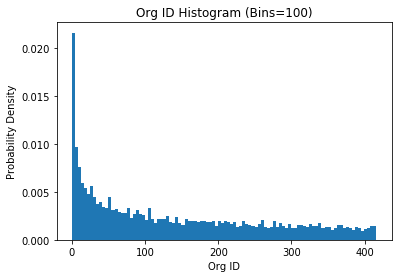

In [253]:
# Histogram
_ = plt.hist(users_clean_y.org_id.values, density=True, bins=100)
_ = plt.xlabel('Org ID')
_ = plt.ylabel('Probability Density')
_ = plt.title('Org ID Histogram (Bins=100)')

The values at 0 denote the dominate the distribution. We just use 10 bins as seen below by using floor value 

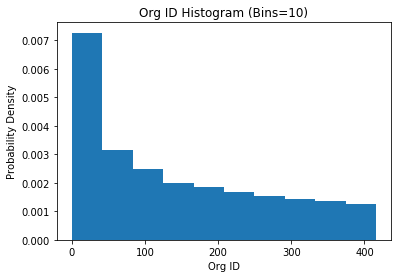

In [254]:
# Histogram
_ = plt.hist(users_clean_y.org_id.values, density=True, bins=10)
_ = plt.xlabel('Org ID')
_ = plt.ylabel('Probability Density')
_ = plt.title('Org ID Histogram (Bins=10)')

In [255]:
# Cut org id in 10 bins
counter_org_id = Counter(users_clean_y.org_id)
bins_org_id = dict(zip(
    list(counter_org_id.keys()), 
    pd.cut(list(counter_org_id.values()), bins=10, labels=False).tolist()))

# Apply function to get bin from map
X_org_id_bin = pd.DataFrame({'org_id_bin': users_clean_y.apply(lambda row: bins_org_id[row['org_id']], axis=1)})
X_org_id_bin_enc = pd.get_dummies(X_org_id_bin.org_id_bin, prefix='org_id_bin')
X_org_id_bin_enc.head()

,org_id_bin_0,org_id_bin_1,org_id_bin_2,org_id_bin_3,org_id_bin_4,org_id_bin_5,org_id_bin_6,org_id_bin_7,org_id_bin_9
0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0


##### Last Session Creation time extraction

To use last session creation time, we will use the difference in creation time and last logged in time and bin them like org id as a predictor.

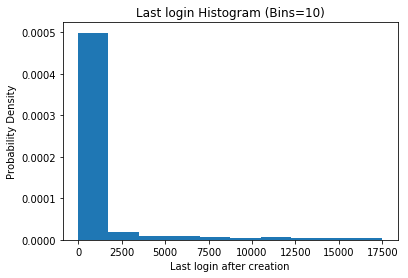

In [265]:
# Get time diff in hours
login_diff = pd.to_datetime(users_clean_y.last_session_creation_time, unit='s') - pd.to_datetime(users_clean_y.creation_time)
login_diff_h = login_diff / pd.Timedelta(hours=1)

# Histogram
_ = plt.hist(login_diff_h.values, density=True, bins=10)
_ = plt.xlabel('Last login after creation')
_ = plt.ylabel('Probability Density')
_ = plt.title('Last login Histogram (Bins=10)')

We use 10 bins again to bin last login times by users. 

In [270]:
# One hot encoding of last login diff times.
X_last_login_bin = pd.DataFrame({'last_login_bin': pd.cut(login_diff_h, bins=10, labels=False).tolist()})
X_last_login_bin_enc = pd.get_dummies(X_last_login_bin.last_login_bin, prefix='last_login_bin')
X_last_login_bin_enc.head()

,last_login_bin_0,last_login_bin_1,last_login_bin_2,last_login_bin_3,last_login_bin_4,last_login_bin_5,last_login_bin_6,last_login_bin_7,last_login_bin_8,last_login_bin_9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


Finally merge the datasets into X, y datasets to use with models.

In [308]:
# Merge X
X = pd.concat([X_creation, X_org_id_bin_enc, X_last_login_bin_enc], axis=1)
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_bin_0,org_id_bin_1,org_id_bin_2,...,last_login_bin_0,last_login_bin_1,last_login_bin_2,last_login_bin_3,last_login_bin_4,last_login_bin_5,last_login_bin_6,last_login_bin_7,last_login_bin_8,last_login_bin_9
0,1,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [309]:
# Set y
y = users_clean_y['y']

#### Model Building

We first split the data set into train/test.

In [310]:
from sklearn.model_selection import train_test_split

# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

We use Logistic Regression and accuracy score as our evaluation metric.

In [311]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(solver='liblinear')

# Fit the model on the trainng data.
clf.fit(X_train, y_train)

# Print the accuracy from the testing data.
print(accuracy_score(y_test, clf.predict(X_test)))

0.7433333333333333


Logistic Regression has parameters that we can train to optimize the results even further such as Regularization parameter. We next examine hyper-parameter tuning of this parameter.

In [312]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1., 10.]

# Hyper-parameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

parameters = {'C':Cs}
cv_grid = GridSearchCV(clf, parameters, cv=5, scoring=make_scorer(accuracy_score), iid=True)
cv_grid.fit(X_train, y_train)
print(cv_grid.best_params_, cv_grid.best_score_)
print(accuracy_score(cv_grid.predict(X_test), y_test))

{'C': 0.1} 0.7398809523809524
0.7433333333333333


#### Best parameters for Logistic Regression

In [313]:
# Get Best Estimator Coefficients
cv_grid.best_estimator_.coef_

array([[ 0.04844871,  0.02991493,  0.18561922,  0.29920901, -1.13176424,
         1.09542638,  1.62474264,  0.23200519,  0.24724926,  0.25749785,
         0.28166977,  0.2506059 ,  0.04778605,  0.19874404,  0.35609532,
         0.20157963, -2.0603859 ,  0.5133706 ,  0.64502831,  0.58760644,
         0.48322315,  0.38250748,  0.47278472,  0.29247293,  0.35855768,
         0.3980676 ]])

In [314]:
lr_best_params = dict(zip(X.columns.tolist(), cv_grid.best_estimator_.coef_[0].tolist()))
lr_best_params_s = sorted(lr_best_params, key=lambda x: abs(lr_best_params[x]), reverse=True)
pd.DataFrame({'feature_name': lr_best_params_s, 'feature_coeff': [lr_best_params[i] for i in lr_best_params_s]}).head(50)

,feature_name,feature_coeff
0,last_login_bin_0,-2.060386
1,creation_source_SIGNUP_GOOGLE_AUTH,1.624743
2,creation_source_PERSONAL_PROJECTS,-1.131764
3,creation_source_SIGNUP,1.095426
4,last_login_bin_2,0.645028
5,last_login_bin_3,0.587606
6,last_login_bin_1,0.513371
7,last_login_bin_4,0.483223
8,last_login_bin_6,0.472785
9,last_login_bin_9,0.398068


We see that how active the user is on the platform (last login) is the best indicator on user adoption, which is expected as users that have not logged in for a long time are mostly likely the non-active users. In addition, how the user signed up is also a great indicator for prediction. Users signed up using Google Authentication, or via website are most likely to be active on the platform. However, users who signed up for doing Personal Projects, do not end up being active on the platform.